In [ ]:
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

from tensorflow.keras.metrics import F1Score
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import AdamW

ModuleNotFoundError: No module named 'tensorflow_text'

In [ ]:
!gdown 15gONUEFE5FtKmZaxaKP6rTyTmxJRF_2s

In [ ]:
!unzip -qq data.zip -d data

replace data/posters/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
movies = pd.read_csv('./data/movies.dat', engine='python',
                     sep='::', names=['id', 'titles', 'genres'], encoding='latin-1', index_col=False).set_index('id')

movies['genres'] = movies.genres.str.split('|')

In [ ]:
idx = movies.index
titles_column_index = movies.columns.get_loc("titles")
movies.insert(titles_column_index, "idx", idx)

img_path = movies.apply(lambda x: os.path.join("./data/posters", f"{x.idx}.jpg"), axis = 1)
movies.insert(titles_column_index + 2, "img_path", img_path)
movies = movies[movies['img_path'].apply(os.path.isfile)]

movies['genres_string'] = movies.apply(lambda x: '[' + ', '.join(map(str, x.genres)) + ']', axis = 1)


<ipython-input-14-25c5d1dbb92c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres_string'] = movies.apply(lambda x: '[' + ', '.join(map(str, x.genres)) + ']', axis = 1)


In [ ]:
movies = movies.groupby("genres_string").filter(lambda x: len(x) > 1)
movies = movies.drop(['genres_string'], axis=1)

import re
movies['titles'] = movies.apply(lambda row: re.compile(r'\s*\(\d{4}\)$').sub('', row.titles), axis = 1)


In [ ]:
# 10% for test
train_df, test_df = train_test_split(
    movies, test_size=0.15, stratify=movies["genres"].values, random_state=42
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)


print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2657
Total validation examples: 235
Total test examples: 235


In [ ]:
train_df["titles"].apply(lambda x: len(x.split(" "))).describe()

count    2657.000000
mean        3.012796
std         1.759822
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        12.000000
Name: titles, dtype: float64

In [ ]:
movies['genres'].values[:5]

array([list(['Animation', "Children's", 'Comedy']),
       list(['Adventure', "Children's", 'Fantasy']),
       list(['Comedy', 'Romance']), list(['Comedy', 'Drama']),
       list(['Comedy'])], dtype=object)

In [ ]:
genres = tf.ragged.constant(movies["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(genres)
vocab = lookup.get_vocabulary()

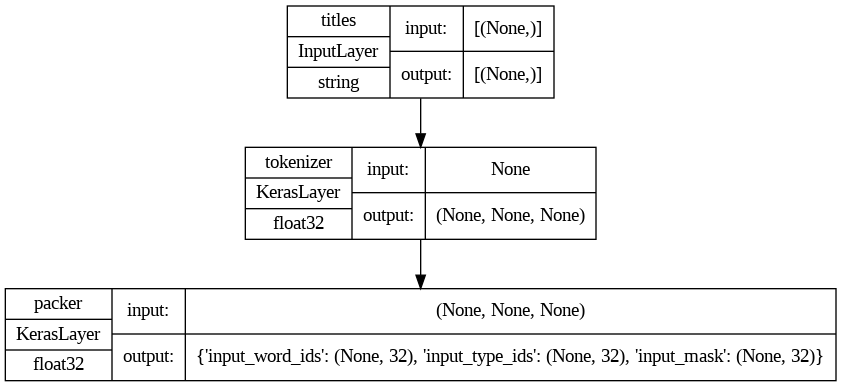

In [ ]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


def make_bert_preprocessing_model(ft):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)

    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segment = [tokenizer(input)]

    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=32),
        name="packer",
    )

    model_inputs = packer(segment)

    return keras.Model(input, model_inputs)


bert_preprocess_model = make_bert_preprocessing_model("titles")
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

In [ ]:
resize = (299, 299)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(title):
    title = tf.convert_to_tensor([title])
    output = bert_preprocess_model(title)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image = preprocess_image(sample["img_path"])
    title = preprocess_text(sample["titles"])
    return {"image": image, "title": title}

In [ ]:
def dataframe_to_dataset(dataframe):
    columns = ["titles", "img_path", 'genres']
    dataframe = dataframe[columns].copy()
    label_binarized = lookup(tf.ragged.constant(dataframe['genres'].values)).numpy()
    dataframe.pop('genres')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), label_binarized))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_df)

In [ ]:
features, label = next(iter(train_ds))

In [ ]:
batch_size = 24
auto = tf.data.AUTOTUNE

def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

train_ds = prepare_dataset(train_df)
val_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

In [ ]:
sample = next(iter(train_ds))

In [ ]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [ ]:
def create_image_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.InceptionV3(
        include_top=False, weights="imagenet"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    image = keras.Input(shape=(299, 299, 3), name="image")

    # Preprocess the input image.
    preprocessed = keras.applications.resnet_v2.preprocess_input(image)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed)

    embeddings = keras.layers.MaxPooling2D(pool_size=(7, 7))(embeddings)
    embeddings = keras.layers.Flatten(name="flatten")(embeddings)
    embeddings = keras.layers.Dense(256, activation="relu")(embeddings)

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(image, outputs, name="image_encoder")


def create_title_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert")
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(32,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="title_encoder")

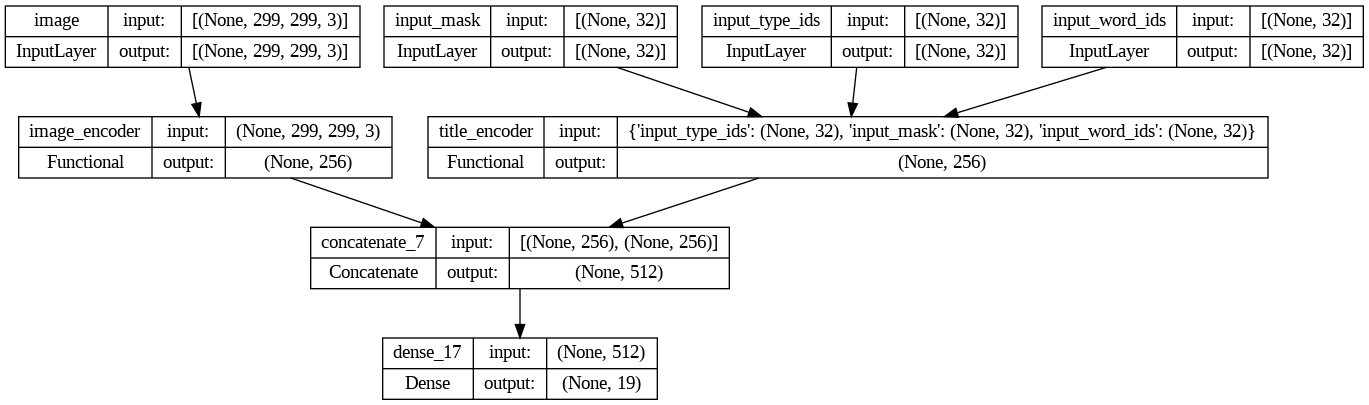

In [ ]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image = keras.Input(shape=(299, 299, 3), name="image")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(32,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    image_encoder = create_image_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    title_encoder = create_title_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    image_projections = image_encoder(image)
    title_projections = title_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([image_projections, title_projections])
    outputs = keras.layers.Dense(lookup.vocabulary_size(), activation="sigmoid")(concatenated)

    return keras.Model([image, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [ ]:
model = create_multimodal_model()

In [ ]:
checkpoint_path = "/content/cp.ckpt/cp.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
os.listdir(checkpoint_dir)


['.ipynb_checkpoints',
 'cp.ckpt.data-00000-of-00001',
 'checkpoint',
 'cp.ckpt.index']

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest


'/content/cp.ckpt/cp.ckpt'

In [ ]:
model.load_weights(latest)


In [ ]:
test_sample = prepare_dataset(test_df.iloc[10:12])
res = model.predict(test_sample)
# res = np.where(res > best_threshold, 1, 0)
res

1/1 [==============================] - 3s 3s/step


array([[3.2199352e-04, 6.1781779e-02, 2.4695868e-02, 4.6106312e-01,
        1.3248824e-01, 9.8609082e-02, 5.0536478e-01, 1.5047775e-01,
        1.2377811e-01, 5.7049410e-04, 8.3871689e-03, 3.9954963e-01,
        7.5838342e-04, 2.2195410e-03, 2.6986610e-02, 3.5493504e-02,
        3.0497483e-03, 2.2515669e-02, 1.8951595e-03],
       [7.2338313e-05, 6.1493850e-01, 6.6360956e-01, 4.5971654e-02,
        2.6044153e-02, 1.9334900e-01, 7.6204119e-04, 1.9159526e-02,
        1.2971042e-01, 7.9928637e-03, 3.7570383e-02, 2.8707895e-02,
        2.6693323e-03, 1.3945657e-03, 3.1370167e-03, 2.1000477e-03,
        1.3820819e-02, 1.7110962e-02, 3.7553548e-03]], dtype=float32)

In [ ]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy", F1Score(average="micro", name="F1Score"), AUC(multi_label=True, num_labels=19, name="AUC")]
)

In [ ]:
_, acc, f1, auc = model.evaluate(test_ds)
print(f"Binary Accuracy on the test set: {round(acc * 100, 2)}%")
print(f"F1-Score on the test set: {round(f1, 2)}")
print(f"AUC on the test set: {round(auc, 2)}")

10/10 [==============================] - 71s 6s/step - loss: 0.2226 - binary_accuracy: 0.9196 - F1Score: 0.4288 - AUC: 0.7331
Binary Accuracy on the test set: 91.96%
F1-Score on the test set: 0.43
AUC on the test set: 0.73


In [ ]:
print(vocab)

['[UNK]', 'Drama', 'Comedy', 'Action', 'Thriller', 'Romance', 'Horror', 'Sci-Fi', 'Adventure', "Children's", 'Crime', 'War', 'Musical', 'Animation', 'Mystery', 'Documentary', 'Western', 'Fantasy', 'Film-Noir']


In [ ]:
test_df.iloc[34:36]

,idx,titles,img_path,genres
id,,,,
2752,2752,Outrageous Fortune,./data/posters/2752.jpg,"[Comedy, Mystery]"
3283,3283,Minnie and Moskowitz,./data/posters/3283.jpg,[Action]


In [ ]:
test_sample = prepare_dataset(test_df.iloc[34:36])
res = model.predict(test_sample)
res

1/1 [==============================] - 2s 2s/step


array([[1.62907963e-04, 7.01835513e-01, 7.86055982e-01, 2.86546885e-03,
        8.41611251e-03, 1.22208573e-01, 4.25114855e-03, 1.56212249e-03,
        3.03700799e-03, 4.11711587e-03, 2.35080913e-01, 3.41784605e-03,
        1.48809263e-02, 1.19110232e-03, 3.30731645e-03, 1.37013812e-02,
        9.90318581e-02, 2.00557569e-03, 6.80098077e-03],
       [1.39327516e-04, 8.89316946e-02, 9.33408499e-01, 2.94668600e-02,
        1.43942442e-02, 2.07376078e-01, 3.16973135e-04, 1.82848703e-02,
        9.55351293e-02, 2.09938195e-02, 9.92423017e-03, 1.26473889e-01,
        2.30301339e-02, 3.22350464e-03, 4.28635580e-03, 1.49800070e-02,
        1.43902665e-02, 1.13305617e-02, 2.56706309e-03]], dtype=float32)

In [ ]:
input_shape = (2, 3, 4)
x1 = np.random.rand(*input_shape)
x2 = np.random.rand(*input_shape)
y = keras.layers.Add()([x1, x2])
z = keras.layers.Average()([x1, x2])
t = keras.layers.Concatenate()([x1, x2])

In [ ]:
x1

array([[[0.40844489, 0.72724108, 0.50884699, 0.35414681],
        [0.04313192, 0.96444867, 0.65879908, 0.92567068],
        [0.53796512, 0.09965232, 0.99137687, 0.99819124]],

       [[0.72422956, 0.12760539, 0.73864995, 0.54588568],
        [0.79844685, 0.21333522, 0.58266842, 0.94320552],
        [0.72149393, 0.11190136, 0.77527319, 0.07390988]]])

In [ ]:
x2

array([[[0.8562929 , 0.38103571, 0.00573328, 0.44096738],
        [0.44036328, 0.38646549, 0.300961  , 0.77353706],
        [0.64763558, 0.42283456, 0.4489975 , 0.59903312]],

       [[0.35530742, 0.39087394, 0.64104728, 0.11800598],
        [0.02223739, 0.69313327, 0.48771867, 0.66434812],
        [0.29687784, 0.97642023, 0.33274217, 0.91058791]]])

In [ ]:
y

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[1.2647378 , 1.1082768 , 0.5145803 , 0.79511416],
        [0.4834952 , 1.3509142 , 0.95976007, 1.6992078 ],
        [1.1856008 , 0.52248687, 1.4403744 , 1.5972244 ]],

       [[1.079537  , 0.51847935, 1.3796973 , 0.6638917 ],
        [0.82068425, 0.9064685 , 1.0703871 , 1.6075537 ],
        [1.0183717 , 1.0883216 , 1.1080154 , 0.9844978 ]]], dtype=float32)>

In [ ]:
z

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[0.6323689 , 0.5541384 , 0.25729015, 0.39755708],
        [0.2417476 , 0.6754571 , 0.47988003, 0.8496039 ],
        [0.5928004 , 0.26124343, 0.7201872 , 0.7986122 ]],

       [[0.5397685 , 0.25923967, 0.68984866, 0.33194584],
        [0.41034213, 0.45323426, 0.53519356, 0.80377686],
        [0.50918585, 0.5441608 , 0.5540077 , 0.4922489 ]]], dtype=float32)>

In [ ]:
t

<tf.Tensor: shape=(2, 3, 8), dtype=float32, numpy=
array([[[0.78416306, 0.6697808 , 0.12287472, 0.89860976, 0.03634666,
         0.4175156 , 0.4148799 , 0.22041713],
        [0.02176247, 0.13377203, 0.81281435, 0.04151931, 0.3511206 ,
         0.8917771 , 0.2768508 , 0.43410578],
        [0.6407678 , 0.40581784, 0.29687423, 0.80407554, 0.91657543,
         0.3296799 , 0.67941177, 0.16429865]],

       [[0.03845093, 0.58514726, 0.5422384 , 0.24454045, 0.27938038,
         0.1332523 , 0.384091  , 0.7564528 ],
        [0.34739226, 0.4720048 , 0.12980175, 0.58137727, 0.7214547 ,
         0.76544386, 0.37637302, 0.59285134],
        [0.42021227, 0.4561836 , 0.40457907, 0.4449676 , 0.7243204 ,
         0.04590843, 0.14613625, 0.06892543]]], dtype=float32)>